# Using Jurassic-1 Large on SageMaker through Model Packages

This sample notebook shows you how to deploy Jurassic-1 Large using Amazon SageMaker.

> **Note**: This is a reference notebook and it cannot run unless you make changes suggested in the notebook.

## Pre-requisites:
1. Before running this notebook, please make sure you got this notebook from the model catalog on SageMaker AWS Management Console.
1. **Note**: This notebook contains elements which render correctly in Jupyter interface. Open this notebook from an Amazon SageMaker Notebook Instance or Amazon SageMaker Studio.
1. Ensure that IAM role used has **AmazonSageMakerFullAccess**.
1. This noebook is intended to work with **boto3 v1.25.4** or higher.

## Contents:
1. [Select model package](#1.-Subscribe-to-the-model-package)
2. [Create an endpoint and perform real-time inference](#2.-Create-an-endpoint-and-perform-real-time-inference)
   1. [Create an endpoint](#A.-Create-an-endpoint)
   2. [Create input payload](#B.-Create-an-input-prompt)
   3. [Perform real-time inference](#C.-Perform-real-time-inference)
   4. [Create the dashboard](#D.-Create-the-dashboard)
   5. [Delete the endpoint](#E.-Delete-the-endpoint)
3. [Clean-up](#4.-Clean-up)
    1. [Delete the model](#A.-Delete-the-model)
    

## Usage instructions
You can run this notebook one cell at a time (By using Shift+Enter for running a cell).

## 1. Select to the model package
Confirm that you recieved this notebook from model catalog on SageMaker AWS Management Console.


In [26]:
model_package_map = {
    "us-east-1": "arn:aws:sagemaker:us-east-1:416407187090:model-package/j1-large-dbf0249",
#     "us-east-1": "arn:aws:sagemaker:us-east-1:865070037744:model-package/j1-grande-dbf0249-66a2031af8f2315babd86234e01824e6",
#     "us-east-2": "arn:aws:sagemaker:us-east-2:057799348421:model-package/j1-grande-dbf0249-66a2031af8f2315babd86234e01824e6",
#     "us-west-1": "arn:aws:sagemaker:us-west-1:382657785993:model-package/j1-grande-dbf0249-66a2031af8f2315babd86234e01824e6",
#     "us-west-2": "arn:aws:sagemaker:us-west-2:594846645681:model-package/j1-grande-dbf0249-66a2031af8f2315babd86234e01824e6",
#     "ca-central-1": "arn:aws:sagemaker:ca-central-1:470592106596:model-package/j1-grande-dbf0249-66a2031af8f2315babd86234e01824e6",
#     "eu-central-1": "arn:aws:sagemaker:eu-central-1:446921602837:model-package/j1-grande-dbf0249-66a2031af8f2315babd86234e01824e6",
#     "eu-west-1": "arn:aws:sagemaker:eu-west-1:985815980388:model-package/j1-grande-dbf0249-66a2031af8f2315babd86234e01824e6",
#     "eu-west-2": "arn:aws:sagemaker:eu-west-2:856760150666:model-package/j1-grande-dbf0249-66a2031af8f2315babd86234e01824e6",
#     "eu-west-3": "arn:aws:sagemaker:eu-west-3:843114510376:model-package/j1-grande-dbf0249-66a2031af8f2315babd86234e01824e6",
#     "eu-north-1": "arn:aws:sagemaker:eu-north-1:136758871317:model-package/j1-grande-dbf0249-66a2031af8f2315babd86234e01824e6",
#     "ap-southeast-1": "arn:aws:sagemaker:ap-southeast-1:192199979996:model-package/j1-grande-dbf0249-66a2031af8f2315babd86234e01824e6",
#     "ap-southeast-2": "arn:aws:sagemaker:ap-southeast-2:666831318237:model-package/j1-grande-dbf0249-66a2031af8f2315babd86234e01824e6",
#     "ap-northeast-2": "arn:aws:sagemaker:ap-northeast-2:745090734665:model-package/j1-grande-dbf0249-66a2031af8f2315babd86234e01824e6",
#     "ap-northeast-1": "arn:aws:sagemaker:ap-northeast-1:977537786026:model-package/j1-grande-dbf0249-66a2031af8f2315babd86234e01824e6",
#     "ap-south-1": "arn:aws:sagemaker:ap-south-1:077584701553:model-package/j1-grande-dbf0249-66a2031af8f2315babd86234e01824e6",
#     "sa-east-1": "arn:aws:sagemaker:sa-east-1:270155090741:model-package/j1-grande-dbf0249-66a2031af8f2315babd86234e01824e6"
}

In [27]:
# SageMaker imports
import json
from sagemaker import ModelPackage
from sagemaker import get_execution_role
from sagemaker import ModelPackage
import sagemaker as sage
import boto3

# Use-case imports
from tqdm import tqdm
from utils.utils import *

### Check the version of boto3 - must be v1.25.4 or higher
If you see a lower version number, pick another kernel to run the notebook, with Python 3.8 or above

In [28]:
boto3.__version__

'1.26.8'

### Install ai21 python SDK

In [29]:
! pip install -U "ai21[SM]"
import ai21

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/tensorflow2_p38/bin/python -m pip install --upgrade pip' command.


In [30]:
region = boto3.Session().region_name
if region not in model_package_map.keys():
    raise ("UNSUPPORTED REGION")

model_package_arn = model_package_map[region]

In [31]:
role = get_execution_role()
sagemaker_session = sage.Session()

runtime_sm_client = boto3.client("runtime.sagemaker")

## 2. Create an endpoint and perform real-time inference

If you want to understand how real-time inference with Amazon SageMaker works, see [Documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/deploy-model.html).

In [32]:
model_name = "j1-large"

content_type = "application/json"

real_time_inference_instance_type = (
    "ml.g5.4xlarge"
)

### A. Create an endpoint

In [33]:
# create a deployable model from the model package.
model = ModelPackage(
    role=role, model_package_arn=model_package_arn, sagemaker_session=sagemaker_session
)

# Deploy the model
predictor = model.deploy(1, real_time_inference_instance_type, endpoint_name=model_name, 
                         model_data_download_timeout=3600,
                         container_startup_health_check_timeout=600,
                        )

ClientError: An error occurred (ValidationException) when calling the CreateEndpointConfig operation: Cannot create already existing endpoint configuration "arn:aws:sagemaker:us-east-1:416407187090:endpoint-config/j1-large".

Once endpoint has been created, you would be able to perform real-time inference.

### B. Interact with the model

You can think of Jurassic-1 Large as a smart auto-completion algorithm: it is very good at latching on to hints and patterns expressed in plain English, and generating text that follows the same patterns.

Here are two words you should know:
- **Prompt** - the input you provide to the model.
- **Completion** - the output text the model generated.

Enter a simple prompt: "To be or", and let the model complete it

In [34]:
response = ai21.Completion.execute(sm_endpoint="j1-large",
                                   prompt="To be or",
                                   maxTokens=4,
                                   temperature=0,
                                   numResults=1)

print(response['completions'][0]['data']['text'])

 not to be? That is the question


As you can see, the model identifies the beginning of a famous quote, and completes it correctly.

### C. Create a few-shot prompt

The best way to guide the model is to provide several examples of input-output pairs in the prompt. This establishes a pattern for the model to mimic. Then add the input for a query example and let the model complete it with an appropriate generation.

In this example, we will create a prompt for analyzing hotel reviews written by users on Hotels.com, and performing freeform sentiment analysis: extracting the topics mentioned in the reviews and assigning a sentiment to each.

To do this, we will build a few-shot prompt comprised of the following:

1. Prefix with several examples. Each example contains the relevant inputs (a review) and the output (extracted topics and sentiments for this review). They are separated by "##".

2. The query inputs. An unseen review for which we would like the model to output topics and sentiments. These should follow the same format of the inputs in the prefix.

First, we collect some example data for the prompt prefix. For this, we will load 19 collected and annotated (by us) reviews for the Empire hotel in Hotels.com

In [43]:
with open("data/hotels_sentimented.jsonl", "r") as fp:
    EXAMPLES_DATA = json.load(fp)

In [44]:
def make_single_example(review, sentiment):   
    example = "Review:\n"
    example += review
    example += "\n"
    example += "Extracted sentiment:\n"
    example += sentiment
    
    return example

SEPARATOR = "\n##\n"

FEW_SHOT_PREFIX = SEPARATOR.join(
    make_single_example(x['review'], json.dumps(x['sentiment'])) for x in EXAMPLES_DATA
)

And finally, we create a function to handle query inputs and create the full prompt:

In [45]:
def create_review_analysis_prompt(review):
    """
    Create a few-shot prompt to analysis reviews with Jurassic-1 Large 
    The prompt contains a preset sequence of examples followed by the query review
    """
    return FEW_SHOT_PREFIX + SEPARATOR + make_single_example(review, '')  # keep the setniment blank and let the model generate

#### Load data to analyze

In [46]:
# Load reviews that were collected from Hotels.com
# This is an array which contains 106 reviews
with open("data/hotelsReviews.json", "r") as fp:
    reviews = json.load(fp)

The prompt is comprised from the following:
1. Few-shot examples: pairs of input-output pairs. In this case, the input is a review and the output is a JSON dictionary containing the categories discussed in the review and their sentiment. They are separated by the following stop sequence: ##.
For example:

    *Review:
    Was overall a good stay. We decided last minute to stay another night. No one really went out of their way to help us stay in the same room so we had to check out and go to a new room. It’s okay tho I understand some of those things are out of some hands.  It also worked out bec our first room’s AC didn’t seem to be working. If I had to complain about one thing, we got a “new” towel from the shower rack (folded) to dry off and the towel smelled like fresh vomit. That was pretty gross. Didn’t really have any other issues other than that. The hotel Is beautiful. 
    Extracted sentiment:
    {"Cleaning": "Negative", "AC": "Negative", "Room Quality": "Positive", "Service": "Negative"}*

2. A review to analyze. It should be written in the same format as all the examples.

### D. Perform real-time inference

Time to put Jurassic-1 Large to work!

Go through all the reviews in the list and call the model on each of them (with the appropriate prompt, of course).
Collect all the sentiments in a list

In [47]:
sentiments = []
for review in tqdm(reviews):
    prompt = create_review_analysis_prompt(review.strip())
  
    response = ai21.Completion.execute(sm_endpoint="j1-large",
                                       prompt=prompt,
                                       maxTokens=150,
                                       temperature=0,
                                       stopSequences=['##'])

    sentiments.append(response['completions'][0]['data']['text'])

100%|██████████| 106/106 [02:32<00:00,  1.44s/it]


Take a look at an arbitrary review and sentiment:

In [40]:
i = 40
print("Review:\n" + reviews[i])
print("=======================")
print("Sentiments:\n" + sentiments[i])

Review:
Air conditioner/heater broke the first night. Repairman in room at 10pm working on it. Thought he fixed it but the room ended up being 78 all night. Next day, Pasqual moved us to a new room. Unfortunately, we had to come back to the hotel from 3-5pm time period to make the switch. He was awesome. Gave us a room with a great view; however, the sink backed up and wouldn’t drain in the new room. Feel like this hotel needs some major repair work done. Main lights on iconic roof sign had letters out. 
Sentiments:
{"AC": "Negative", "Room Quality": "Negative", "Hotel Facilities": "Negative", "Service": "Negative"}



### D. Create the dashboard

These functions take all the extracted categories and sentiments, and do the following:
1. Gather all of the categories together, assigning a count of "Positive" or "Negative" to each category.
2. Take the top count categories to display in the dashboard

In [48]:
scores, category_names = get_topK_categories_and_score(sentiments, k=5)

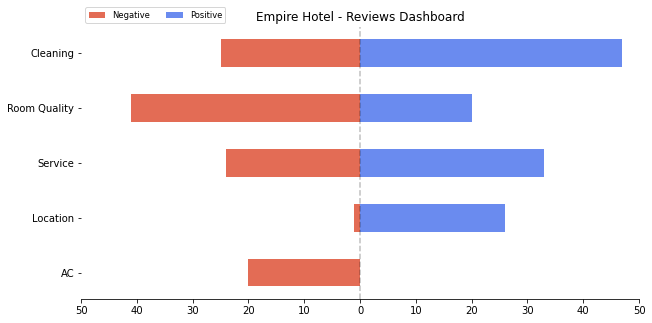

In [49]:
fig, ax = plot_dashboard(scores, category_names)
plt.show()

### Interested in learning more?
Take a look at our [blog post](https://www.ai21.com/blog/build-a-dashboard-based-on-freeform-sentiment-analysis-of-hotel-reviews) to understand the process of building a good prompt.

### E. Delete the endpoint

Now that you have successfully performed a real-time inference, you do not need the endpoint any more. You can terminate the endpoint to avoid being charged.

In [ ]:
model.sagemaker_session.delete_endpoint(model_name)
model.sagemaker_session.delete_endpoint_config(model_name)

## 4. Clean-up

### A. Delete the model

In [75]:
model.delete_model()